<h1>Taxi demand prediction<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory data analysis</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model evaluation</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Introduction

We are given a large dataframe with information about taxi trips in Chicago and surrounding areas in 2022. The aim of this project is to predict next hour's taxi demand for each Chicago community area. The project will be divided into the following sections:

    0. Introduction - brief overview of the notebook
    1. Data preprocessing - cleaning the dataset and joining, grouping, ordering it with pyspark
    2. EDA - plotting time-series data of the busiest area
    3. Feature engineering - adding new time-series features to the grouped dataframe
    4. Model training - preparing data for ML and training the model
    5. Model evaluation - checking how predictions match with the actual data
    6. Conclusion - brief summarizon of the work

# Data preprocessing

In [114]:
# for general purposes
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# for data viz
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from plotly_calplot import calplot

# for big data processing
import pyspark 
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# for data engineering
import holidays

# for model training
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from itertools import product

The following configurations were added to the spark session to ensure stable work on a computer with 4 cores and ~4GB avaliable RAM

In [2]:
spark = SparkSession.builder \
    .appName("pyspark_taxi_forecasting") \
    .config("spark.master", "local[2]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "2") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.default.parallelism", "8") \
    .config("spark.driver.maxResultSize", "500m") \
    .config("spark.ui.enabled", "true") \
    .config("spark.driver.bindAddress", "localhost") \
    .config("spark.ui.port", "4040") \
    .config("spark.submit.pyFiles", "") \
    .config("spark.python.worker.logService.enabled", "true") \
    .config("spark.python.worker.connect.timeout", "10s") \
    .getOrCreate()

Spark UI contains valuable information about processing stages

In [3]:
spark.getActiveSession()

We could try to infer schema in the read.csv function, but outlining the types explicitly will slightly boost performance. Dollar signs of monetary columns will be removed later. Location columns are redundant and will be deleted, since we already have latitude and longitude

In [4]:
schema = StructType([
    StructField("trip_id", StringType(), nullable=True),
    StructField("taxi_id", StringType(), nullable=True),
    StructField("start", TimestampType(), nullable=True),
    StructField("end", TimestampType(), nullable=True),
    StructField("duration", FloatType(), nullable=True),
    StructField("distance", FloatType(), nullable=True),
    StructField("pickup_tract", StringType(), nullable=True),
    StructField("dropoff_tract", StringType(), nullable=True),
    StructField("pickup_area", IntegerType(), nullable=True),
    StructField("dropoff_area", IntegerType(), nullable=True),
    StructField("fare", StringType(), nullable=True),
    StructField("tip", StringType(), nullable=True),
    StructField("tolls", StringType(), nullable=True),
    StructField("extras", StringType(), nullable=True),
    StructField("trip_total", StringType(), nullable=True),
    StructField("payment_type", StringType(), nullable=True),
    StructField("company", StringType(), nullable=True),
    StructField("pickup_lat", FloatType(), nullable=True),
    StructField("pickup_long", FloatType(), nullable=True),
    StructField("pickup_loc", StringType(), nullable=True),
    StructField("dropoff_lat", FloatType(), nullable=True),
    StructField("dropoff_long", FloatType(), nullable=True),
    StructField("dropoff_loc", StringType(), nullable=True)]
)

In [5]:
data = spark.read.csv(path='taxi_trips_22.csv', 
                      schema=schema, 
                      header=True, 
                      timestampFormat="MM/dd/yyyy hh:mm:ss a")

In [6]:
data = data.drop("pickup_loc", "dropoff_loc")

In [7]:
dollar_sign_columns = ["fare", "tip", "tolls", "extras", "trip_total"]

for column_name in dollar_sign_columns:
    data = data.withColumn(column_name, 
                           regexp_replace(col(column_name), 
                                            "\\$", 
                                            ""
                                           ).cast(DoubleType())
                          )

In [8]:
data.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- end: timestamp (nullable = true)
 |-- duration: float (nullable = true)
 |-- distance: float (nullable = true)
 |-- pickup_tract: string (nullable = true)
 |-- dropoff_tract: string (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_lat: float (nullable = true)
 |-- pickup_long: float (nullable = true)
 |-- dropoff_lat: float (nullable = true)
 |-- dropoff_long: float (nullable = true)



The dataframe contains 6,382,425 rows before processing. 

Pickup areas outside of Chicago are of little interest, since we are trying to estimate demand in Chicago specifically. Hence, the missing values of the 'pickup_area' column, that denote locations outside of Chicago, will be removed

In [9]:
data = data.na.drop(subset=['pickup_area'])

Since we are trying to predict the demand for the next hour, we have to group data by a truncated 'start' column

In [10]:
grouped = data.groupBy("pickup_area", date_trunc('hour', 'start').alias("pickup_hour")) \
              .count() \
              .orderBy("pickup_area", "pickup_hour")

In [11]:
grouped.printSchema()

root
 |-- pickup_area: integer (nullable = true)
 |-- pickup_hour: timestamp (nullable = true)
 |-- count: long (nullable = false)



In [12]:
grouped.count()

380919

In [13]:
grouped.show(25)

+-----------+-------------------+-----+
|pickup_area|        pickup_hour|count|
+-----------+-------------------+-----+
|          1|2022-01-01 00:00:00|    1|
|          1|2022-01-01 01:00:00|    2|
|          1|2022-01-01 02:00:00|    3|
|          1|2022-01-01 03:00:00|    5|
|          1|2022-01-01 04:00:00|    4|
|          1|2022-01-01 06:00:00|    1|
|          1|2022-01-01 07:00:00|    4|
|          1|2022-01-01 08:00:00|    3|
|          1|2022-01-01 09:00:00|    5|
|          1|2022-01-01 10:00:00|    5|
|          1|2022-01-01 11:00:00|    4|
|          1|2022-01-01 12:00:00|    4|
|          1|2022-01-01 13:00:00|    6|
|          1|2022-01-01 14:00:00|    5|
|          1|2022-01-01 15:00:00|    4|
|          1|2022-01-01 16:00:00|    2|
|          1|2022-01-01 17:00:00|    1|
|          1|2022-01-01 18:00:00|    2|
|          1|2022-01-01 19:00:00|    2|
|          1|2022-01-01 20:00:00|    3|
|          1|2022-01-01 21:00:00|    1|
|          1|2022-01-01 22:00:00|    3|


In [14]:
print(f'There supposed to be {24*365*77} rows in our dataframe, but we have only 380,919 instead')

There supposed to be 674520 rows in our dataframe, but we have only 380,919 instead


The grouped data now might contain missing hours for some areas. For example, area 1: "2022-01-02 01:00:00". This might lead to problems later when we make lags and other engineered features. It would also omit valuable information for the model. To counter that, we need to create a dummy dataframe with no missing hours for every area, then join it with 'grouped'. The 'count' column for the added hours will be filled with zeros. Here is the code below

In [15]:
# The dates are selected in such a way that, after conversion 
# to a pyspark dataframe, we will have the required dates from 
# 2022-01-01 00:00:00 to 2022-12-31 23:00:00.
# Additionally, the timezone is set to Chicago, since
# it is reset on March, 13 and November, 6 at 2 AM by 1 hour

df = pd.date_range(start="2021-12-31 17:00:00", 
                   end="2022-12-31 16:00:00", 
                   freq="1H",
                   tz='America/Chicago'
                  )
df = pd.DataFrame(df, columns=["pickup_hour"])
df['pickup_area'] = 0
final_df = pd.DataFrame([], columns=['pickup_hour', 'pickup_area'])

for i in range(1, 78):
    df['pickup_area'] = i
    final_df = pd.concat([final_df, df], axis=0)
    
final_df['pickup_area'] = final_df['pickup_area'].astype('int64')

spark.createDataFrame() did not manage to make a pypsark dataframe with an error "Python worker failed to connect back". It might have been a memory issue. Below I tried to save Pandas dataframe as a csv file and read it with spark

In [16]:
final_df.to_csv('hours_2022.csv', index=False)

In [17]:
dummy_schema = StructType([StructField("pickup_hour", TimestampType(), True),
                           StructField("pickup_area", IntegerType(), True)])

In [18]:
final_df = spark.read.csv(path='hours_2022.csv', 
                          schema=dummy_schema,
                          header=True)

In [19]:
grouped = grouped.join(final_df, on=["pickup_area", "pickup_hour"], how="right_outer") \
                 .orderBy("pickup_area", "pickup_hour")
grouped = grouped.fillna({"count": 0})

In [20]:
grouped.count()

674520

In [21]:
grouped.show(25)

+-----------+-------------------+-----+
|pickup_area|        pickup_hour|count|
+-----------+-------------------+-----+
|          1|2022-01-01 00:00:00|    1|
|          1|2022-01-01 01:00:00|    2|
|          1|2022-01-01 02:00:00|    3|
|          1|2022-01-01 03:00:00|    5|
|          1|2022-01-01 04:00:00|    4|
|          1|2022-01-01 05:00:00|    0|
|          1|2022-01-01 06:00:00|    1|
|          1|2022-01-01 07:00:00|    4|
|          1|2022-01-01 08:00:00|    3|
|          1|2022-01-01 09:00:00|    5|
|          1|2022-01-01 10:00:00|    5|
|          1|2022-01-01 11:00:00|    4|
|          1|2022-01-01 12:00:00|    4|
|          1|2022-01-01 13:00:00|    6|
|          1|2022-01-01 14:00:00|    5|
|          1|2022-01-01 15:00:00|    4|
|          1|2022-01-01 16:00:00|    2|
|          1|2022-01-01 17:00:00|    1|
|          1|2022-01-01 18:00:00|    2|
|          1|2022-01-01 19:00:00|    2|
|          1|2022-01-01 20:00:00|    3|
|          1|2022-01-01 21:00:00|    1|


Adding new features to the grouped dataframe

In [22]:
# dayofweek assigns 1 to Sunday and 7 to Saturday

grouped = grouped.withColumn("quarter", quarter("pickup_hour")) \
        .withColumn("month", month("pickup_hour")) \
        .withColumn("day", dayofmonth("pickup_hour")) \
        .withColumn("weekday", dayofweek("pickup_hour")) \
        .withColumn("day_of_year", dayofyear("pickup_hour")) \
        .withColumn("week", weekofyear("pickup_hour")) \
        .withColumn("hour", hour("pickup_hour"))

In [23]:
# 1 - for Spring
# 2 - for Summmer
# 3 - for Fall
# 4 - for Winter

grouped = grouped.withColumn(
    "season",
    when(col("month").between(3, 5), 1)
    .when(col("month").between(6, 8), 2)
    .when(col("month").between(9, 11), 3)
    .otherwise(4),
)

In [24]:
# 1 - from 00:00 to 05:59
# 2 - from 06:00 to 11:59
# 3 - from 12:00 to 17:59
# 4 - from 18:00 to 23:59

grouped = grouped.withColumn(
    "time",
    when(col("hour").between(0, 5), 1)
    .when(col("hour").between(6, 11), 2)
    .when(col("hour").between(12, 17), 3)
    .otherwise(4),
)

In [25]:
grouped.show(5)

+-----------+-------------------+-----+-------+-----+---+-------+-----------+----+----+------+----+
|pickup_area|        pickup_hour|count|quarter|month|day|weekday|day_of_year|week|hour|season|time|
+-----------+-------------------+-----+-------+-----+---+-------+-----------+----+----+------+----+
|          1|2022-01-01 00:00:00|    1|      1|    1|  1|      7|          1|  52|   0|     4|   1|
|          1|2022-01-01 01:00:00|    2|      1|    1|  1|      7|          1|  52|   1|     4|   1|
|          1|2022-01-01 02:00:00|    3|      1|    1|  1|      7|          1|  52|   2|     4|   1|
|          1|2022-01-01 03:00:00|    5|      1|    1|  1|      7|          1|  52|   3|     4|   1|
|          1|2022-01-01 04:00:00|    4|      1|    1|  1|      7|          1|  52|   4|     4|   1|
+-----------+-------------------+-----+-------+-----+---+-------+-----------+----+----+------+----+
only showing top 5 rows



In [26]:
grouped.printSchema()

root
 |-- pickup_area: integer (nullable = true)
 |-- pickup_hour: timestamp (nullable = true)
 |-- count: long (nullable = false)
 |-- quarter: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- day_of_year: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- season: integer (nullable = false)
 |-- time: integer (nullable = false)



In [27]:
%who DataFrame

data	 df	 final_df	 grouped	 


In [28]:
del df, final_df

In [29]:
grouped.cache()

DataFrame[pickup_area: int, pickup_hour: timestamp, count: bigint, quarter: int, month: int, day: int, weekday: int, day_of_year: int, week: int, hour: int, season: int, time: int]

Interim conclusion:

    The given dataframe was cleaned off missing values that correspond to locations outside of Chicago. It was then grouped and ordered by every community area and pickup hour, the number of trips was calculated. Then missing values for the hours were added and the corresponding 'count' column was filled in with 0. New time-series data was added: quarter, month, day, weekday, day_of_year, week, hour, season, time of day. We will need it in the next EDA section

# Exploratory data analysis

As we will see, the demand is non-homogeneous and differs by area. Hence, it makes little sense to explore the demand as a whole. The following section analyses taxi demand for the busiest area. The functions for plotting are customized so that we can plot the same graphs for another area if we need to

The plot below shows the number of times taxi services were used in every Chicago community area throughout year 2022. Areas 8, 28, 32, 76 are the busiest

In [30]:
# The following code is added to optimize conversion of a pyspark dataframe to pandas 
# that we will need in data viz

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

<AxesSubplot:title={'center':'Demand by community area'}, xlabel='count', ylabel='pickup_area'>

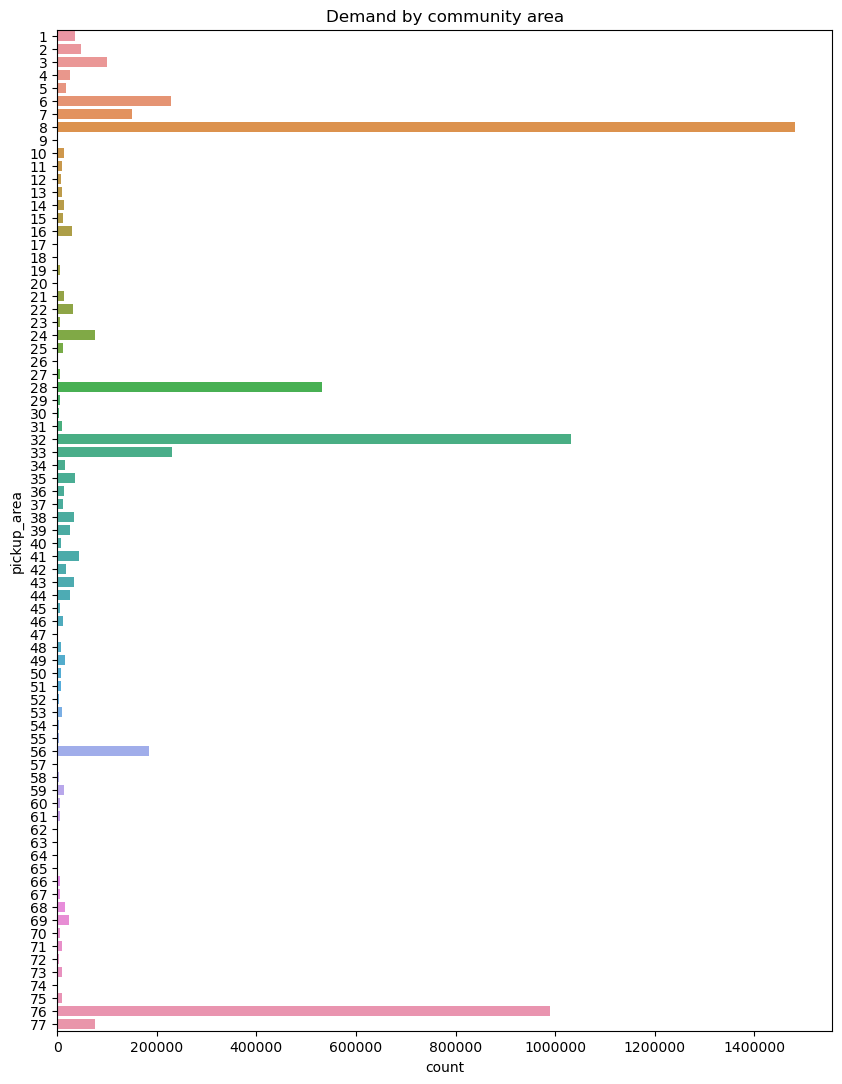

In [31]:
eda = grouped.groupBy('pickup_area').agg(sum('count').alias('count'))
eda = eda.toPandas()

plt.figure(figsize=(10,13))
plt.title('Demand by community area')
plt.ticklabel_format(style='plain', axis='x')
sns.barplot(data=eda, y='pickup_area',  x='count', orient='h')

Chicago community areas can be seen here

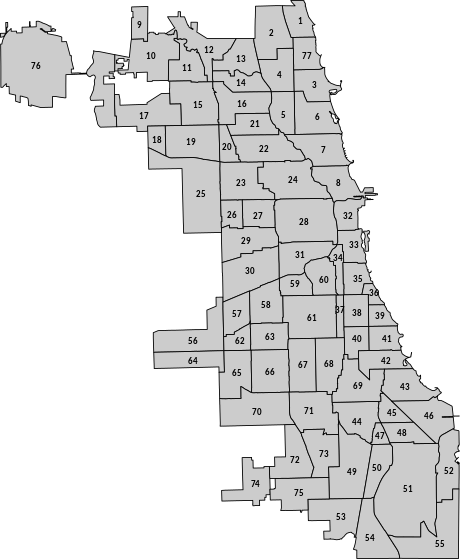

A more detailed and descriptive plot is shown below

In [32]:
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

folium.Choropleth(
    geo_data="chicago-community-areas.geojson",
    name="choropleth",
    data=eda,
    columns=["pickup_area", "count"],
    key_on="feature.properties.area_num_1",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Taxi Demand",
    smooth_factor=0,
).add_to(m)
folium.LayerControl().add_to(m)

m

In [33]:
del eda

In [34]:
def plot_calendar(area):
    
    cal = grouped.filter(grouped.pickup_area==area) \
             .groupBy(col('pickup_hour').cast('date').alias('date')) \
             .agg(sum('count').alias('demand')) \
             .orderBy('date')
    cal = cal.toPandas()
    cal['date'] = pd.to_datetime(cal['date'])
    
    minimum = cal['demand'].min()
    maximum = cal['demand'].max()
    delta = maximum - minimum
    q1 = cal['demand'].quantile(0.25)/delta
    q3 = cal['demand'].quantile(0.75)/delta
    iqr = q3 - q1
    out1 = q1 - 1.5*iqr
    out2 = q3 + 1.5*iqr
    
    if out1>0.0 and out2<1.0:
        colorscale = [(0.00, "yellow"), (out1, "#75E6DA"),
                    (out1, "#75E6DA"), (q1, "#189AB4"),
                    (q1, "#189AB4"), (q3, "#05445E"),
                    (q3, "#05445E"), (out2, "#0000FF"),
                    (out2, "#0000FF"), (1.00, "red")]
    elif out1>0.0 and out2>1.0:
        colorscale = [(0.00, "yellow"), (out1, "#75E6DA"),
                    (out1, "#75E6DA"), (q1, "#189AB4"),
                    (q1, "#189AB4"), (q3, "#05445E"),
                    (q3, "#05445E"), (1, "#0000FF")]
    elif out1<0.0 and out2<1.0:
        colorscale = [(0.00, "#75E6DA"), (q1, "#189AB4"),
                    (q1, "#189AB4"), (q3, "#05445E"),
                    (q3, "#05445E"), (out2, "#0000FF"),
                    (out2, "#0000FF"), (1.00, "red")]
    elif out1<0.0 and out2>1.0:
        colorscale = [(0.00, "#75E6DA"), (q1, "#189AB4"),
                    (q1, "#189AB4"), (q3, "#05445E"),
                    (q3, "#05445E"), (1.00, "#0000FF")]
    
    fig = calplot(
        cal,
        x="date",
        y="demand",
        dark_theme=True,
        colorscale=colorscale,
        gap=1,
        name="demand",
        month_lines_width=3, 
        month_lines_color="#555152",
        title=f'Taxi demand in community area {area} in 2022',
        showscale=True,
        total_height=200,
    )
    fig.update_layout(
        margin=dict(t=50, b=20),
    )
    
    return fig

Below you can see a calendar plot of taxi demand for an area. Some community areas do not have days with abnormally small or exceedingly large taxi demand, others have both. January seems to be the least busy month. Moreover, people use taxis more often from Tuesday to Saturday

    Yellow - for small outliers
    Red - for large outliers
    
    Pale blue - for small normal values
    Dark blue - for values between the 1st and 3d quartiles
    Radiant blue - for large normal values

In [35]:
plot_calendar(8)

In [105]:
def plot_day(area):
        
    cal = grouped.filter(grouped.pickup_area==area) \
         .groupBy(col('pickup_hour').cast('date').alias('date')) \
         .agg(sum('count').alias('demand')) \
         .orderBy('date')
    cal = cal.toPandas()
    
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=45)
    plt.title(f'Taxi demand by day in community area {area}')
    fig = sns.lineplot(data=cal, x='date', y='demand')
    
    return fig

<AxesSubplot:title={'center':'Taxi demand by day in community area 8'}, xlabel='date', ylabel='demand'>

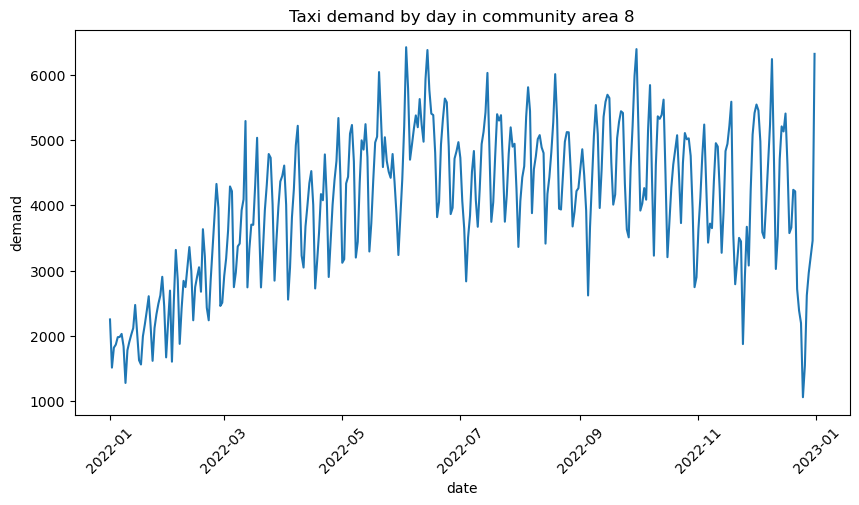

In [106]:
plot_day(8)

In [36]:
def plot_hour(area):
    
    time = grouped.filter(grouped.pickup_area==area) \
                  .groupBy('hour') \
                  .agg(median('count').alias('demand')) \
                  .orderBy('hour')
    time = time.toPandas()
    time['hour'] = time['hour'].astype('str') + ':00'
    
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=45)
    plt.title(f'Median demand by hour in community area {area}')
    fig = sns.lineplot(data=time, x='hour', y='demand')
    
    return fig

<AxesSubplot:title={'center':'Median demand by hour in community area 8'}, xlabel='hour', ylabel='demand'>

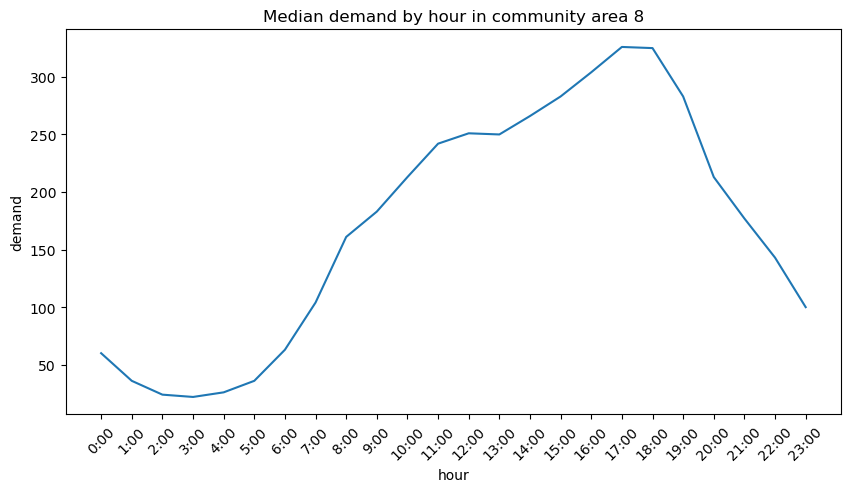

In [37]:
plot_hour(8)

In [38]:
def plot_time(area):
    
    time = grouped.filter(grouped.pickup_area==area) \
                  .groupBy('time') \
                  .agg(median('count').alias('demand')) \
                  .orderBy('time')
    time = time.toPandas()
    
    time_of_day = {1: '00:00-05:59', 
                   2: '06:00-11:59', 
                   3: '12:00-17:59', 
                   4: '18:00-23:59'}
    
    time['time'] = time['time'].replace(time_of_day)
    
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=45)
    plt.title(f'Median demand by time of day in community area {area}')
    fig = sns.barplot(data=time, x='time', y='demand')
    
    return fig

<AxesSubplot:title={'center':'Median demand by time of day in community area 8'}, xlabel='time', ylabel='demand'>

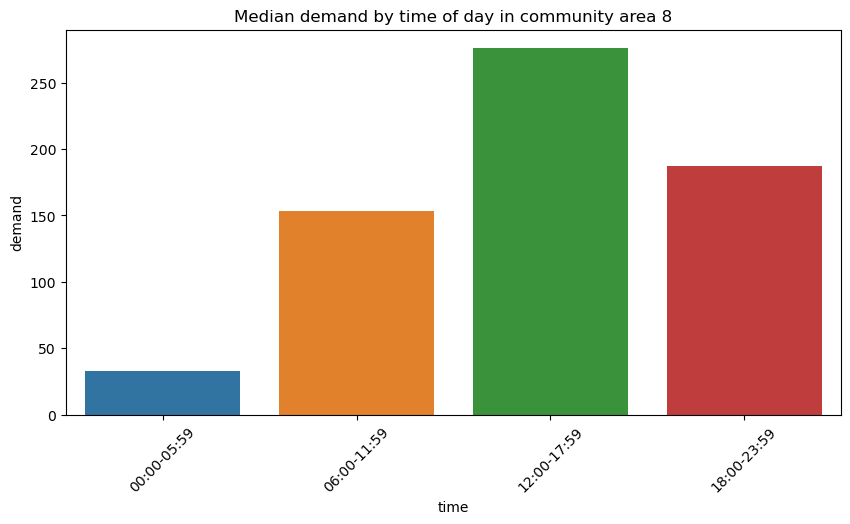

In [39]:
plot_time(8)

In [40]:
def plot_weekday(area):
    
    time = grouped.filter(grouped.pickup_area==area) \
                  .groupBy('weekday') \
                  .agg(median('count').alias('demand')) \
                  .orderBy('weekday')
    time = time.toPandas()
    
    days = {1: 'Sunday', 
            2: 'Monday',
            3: 'Tuesday',
            4: 'Wednesday',
            5: 'Thursday',
            6: 'Friday',
            7: 'Saturday'}
    
    time['weekday'] = time['weekday'].replace(days)
    
    plt.figure(figsize=(7,5))
    plt.xticks(rotation=45)
    plt.title(f'Median demand by weekday in community area {area}')
    fig = sns.barplot(data=time, x='weekday', y='demand')
    
    return fig

<AxesSubplot:title={'center':'Median demand by weekday in community area 8'}, xlabel='weekday', ylabel='demand'>

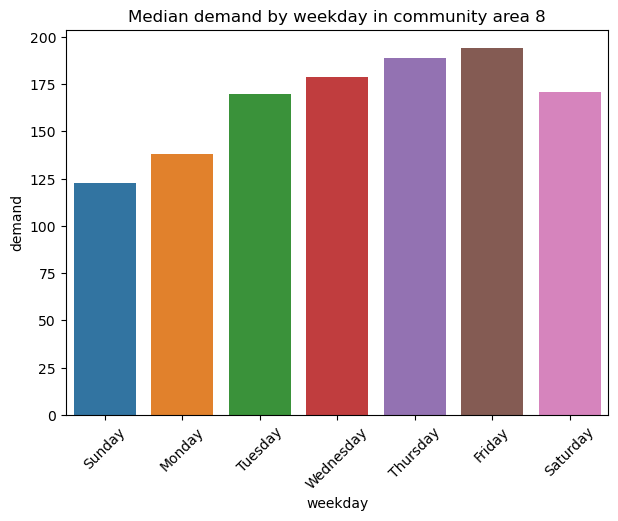

In [41]:
plot_weekday(8)

In [42]:
def plot_month(area):
    
    time = grouped.filter(grouped.pickup_area==area) \
                  .groupBy('month') \
                  .agg(median('count').alias('demand')) \
                  .orderBy('month')
    time = time.toPandas()
    
    months = {1: 'January', 
              2: 'February',
              3: 'March',
              4: 'April',
              5: 'May',
              6: 'June',
              7: 'July',
              8: 'August',
              9: 'September',
              10: 'October',
              11: 'November',
              12: 'December'}
    
    time['month'] = time['month'].replace(months)
    
    plt.figure(figsize=(12,5))
    plt.title(f'Median demand by month in community area {area}')
    fig = sns.barplot(data=time, x='month', y='demand')
    
    return fig

<AxesSubplot:title={'center':'Median demand by month in community area 8'}, xlabel='month', ylabel='demand'>

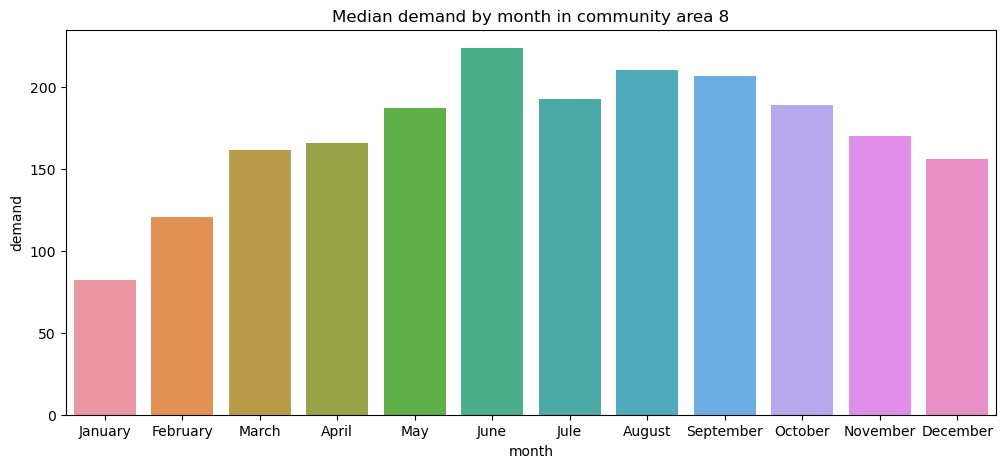

In [43]:
plot_month(8)

Interim conclusion:

    The busiest areas are 8, 32 and 76 (which is an airport). Most areas have under 0.25 million taxi trips a year, others have up to 1.5 million. The busiest area 8 has stable taxi demand thoughout the year, that is there are few days with abnormally low demand and no days with exceedingly high demand. Demand oscillates by month, week and hour. The most productive months are June, August and September, the least productive are January and February. People are most active on Friday and need taxi services the least on Sunday and Monday. The busiest hours are from 12:00 to 18:00

# Feature engineering

Creating lags and rolling means. Rolling mean was calculated with a shift to prevent target leakage. Holidays were added as well

In [44]:
window = Window.partitionBy("pickup_area").orderBy("pickup_hour")
grouped = grouped.withColumn("lag_1", lag("count", 1).over(window))
grouped = grouped.withColumn("lag_2", lag("count", 2).over(window))
grouped = grouped.withColumn("lag_3", lag("count", 3).over(window))
grouped = grouped.withColumn("lag_24", lag("count", 24).over(window))

In [45]:
rm_window = (Window.partitionBy("pickup_area")
                   .orderBy("pickup_hour")
            ).rowsBetween(-3, 0)
grouped = grouped.withColumn("rolling_mean_3", avg('lag_1').over(rm_window))

rm_window = (Window.partitionBy("pickup_area")
                   .orderBy("pickup_hour")
            ).rowsBetween(-6, 0)
grouped = grouped.withColumn("rolling_mean_6", avg('lag_1').over(rm_window))

rm_window = (Window.partitionBy("pickup_area")
                   .orderBy("pickup_hour")
            ).rowsBetween(-12, 0)
grouped = grouped.withColumn("rolling_mean_12", avg('lag_1').over(rm_window))

rm_window = (Window.partitionBy("pickup_area")
                   .orderBy("pickup_hour")
            ).rowsBetween(-24, 0)
grouped = grouped.withColumn("rolling_mean_24", avg('lag_1').over(rm_window))

In [46]:
us_holidays = holidays.US(subdiv='IL', years=2022)

for date, name in sorted(us_holidays.items()):
    print(date, name)

2022-01-01 New Year's Day
2022-01-17 Martin Luther King Jr. Day
2022-02-11 Lincoln's Birthday (Observed)
2022-02-12 Lincoln's Birthday
2022-02-21 Washington's Birthday
2022-03-07 Casimir Pulaski Day
2022-05-30 Memorial Day
2022-06-19 Juneteenth National Independence Day
2022-06-20 Juneteenth National Independence Day (Observed)
2022-07-04 Independence Day
2022-09-05 Labor Day
2022-10-10 Columbus Day
2022-11-08 Election Day
2022-11-11 Veterans Day
2022-11-24 Thanksgiving
2022-12-25 Christmas Day
2022-12-26 Christmas Day (Observed)


In [47]:
# adding Valentine's, Lunar Year, St. Patrick's,
# Good Friday, Halloween, New Year's Eve and days before them

us_holidays = list(us_holidays.keys())

for date in ['2022-02-14',
             '2022-02-01', 
             '2022-03-17', 
             '2022-04-15', 
             '2022-10-31',
             '2022-12-31']:
    us_holidays.append(datetime.strptime(date, '%Y-%m-%d').date())
    
for date in us_holidays.copy():
    prev_day = date - timedelta(days=1)
    us_holidays.append(prev_day)
    
us_holidays.sort()
us_holidays = set(us_holidays)

In [48]:
us_holidays

{datetime.date(2021, 12, 31),
 datetime.date(2022, 1, 1),
 datetime.date(2022, 1, 16),
 datetime.date(2022, 1, 17),
 datetime.date(2022, 1, 31),
 datetime.date(2022, 2, 1),
 datetime.date(2022, 2, 10),
 datetime.date(2022, 2, 11),
 datetime.date(2022, 2, 12),
 datetime.date(2022, 2, 13),
 datetime.date(2022, 2, 14),
 datetime.date(2022, 2, 20),
 datetime.date(2022, 2, 21),
 datetime.date(2022, 3, 6),
 datetime.date(2022, 3, 7),
 datetime.date(2022, 3, 16),
 datetime.date(2022, 3, 17),
 datetime.date(2022, 4, 14),
 datetime.date(2022, 4, 15),
 datetime.date(2022, 5, 29),
 datetime.date(2022, 5, 30),
 datetime.date(2022, 6, 18),
 datetime.date(2022, 6, 19),
 datetime.date(2022, 6, 20),
 datetime.date(2022, 7, 3),
 datetime.date(2022, 7, 4),
 datetime.date(2022, 9, 4),
 datetime.date(2022, 9, 5),
 datetime.date(2022, 10, 9),
 datetime.date(2022, 10, 10),
 datetime.date(2022, 10, 30),
 datetime.date(2022, 10, 31),
 datetime.date(2022, 11, 7),
 datetime.date(2022, 11, 8),
 datetime.date(202

In [49]:
# broadcast is added to speed things up
us_holidays_broadcast = spark.sparkContext.broadcast(us_holidays)

def is_holiday(date_column):
    return col(date_column).cast(DateType()).isin(us_holidays_broadcast.value)

grouped = grouped.withColumn('holiday', is_holiday('pickup_hour'))

In [50]:
grouped = grouped.withColumn('holiday', grouped.holiday.cast(IntegerType()))

A part of the pyspark dataframe was converted to Pandas for better readability

In [51]:
pd.set_option('display.max_columns', None)

In [52]:
pd.DataFrame(grouped.orderBy('pickup_area', 'pickup_hour').take(28), columns=grouped.columns)

pickup_area         pickup_hour  count  quarter  month  day  weekday  \
0             1 2022-01-01 00:00:00      1        1      1    1        7   
1             1 2022-01-01 01:00:00      2        1      1    1        7   
2             1 2022-01-01 02:00:00      3        1      1    1        7   
3             1 2022-01-01 03:00:00      5        1      1    1        7   
4             1 2022-01-01 04:00:00      4        1      1    1        7   
5             1 2022-01-01 05:00:00      0        1      1    1        7   
6             1 2022-01-01 06:00:00      1        1      1    1        7   
7             1 2022-01-01 07:00:00      4        1      1    1        7   
8             1 2022-01-01 08:00:00      3        1      1    1        7   
9             1 2022-01-01 09:00:00      5        1      1    1        7   
10            1 2022-01-01 10:00:00      5        1      1    1        7   
11            1 2022-01-01 11:00:00      4        1      1    1        7   
12            1 2022-01-01 12:00:00      4        1      1    1        7   
13            1 2022-01-01 13:00:00      6        1      1    1        7   
14            1 2022-01-01 14:00:00      5        1      1    1        7   
15            1 2022-01-01 15:00:00      4        1      1    1        7   
16            1 2022-01-01 16:00:00      2        1      1    1        7   
17            1 2022-01-01 17:00:00      1        1      1    1        7   
18            1 2022-01-01 18:00:00      2        1      1    1        7   
19            1 2022-01-01 19:00:00      2        1      1    1        7   
20            1 2022-01-01 20:00:00      3        1      1    1        7   
21            1 2022-01-01 21:00:00      1        1      1    1        7   
22            1 2022-01-01 22:00:00      3        1      1    1        7   
23            1 2022-01-01 23:00:00      2        1      1    1        7   
24            1 2022-01-02 00:00:00      1        1      1    2        1   
25            1 2022-01-02 01:00:00      0        1      1    2        1   
26            1 2022-01-02 02:00:00      2        1      1    2        1   
27            1 2022-01-02 03:00:00      1        1      1    2        1   

    day_of_year  week  hour  season  time  lag_1  lag_2  lag_3  lag_24  \
0             1    52     0       4     1    NaN    NaN    NaN     NaN   
1             1    52     1       4     1    1.0    NaN    NaN     NaN   
2             1    52     2       4     1    2.0    1.0    NaN     NaN   
3             1    52     3       4     1    3.0    2.0    1.0     NaN   
4             1    52     4       4     1    5.0    3.0    2.0     NaN   
5             1    52     5       4     1    4.0    5.0    3.0     NaN   
6             1    52     6       4     2    0.0    4.0    5.0     NaN   
7             1    52     7       4     2    1.0    0.0    4.0     NaN   
8             1    52     8       4     2    4.0    1.0    0.0     NaN   
9             1    52     9       4     2    3.0    4.0    1.0     NaN   
10            1    52    10       4     2    5.0    3.0    4.0     NaN   
11            1    52    11       4     2    5.0    5.0    3.0     NaN   
12            1    52    12       4     3    4.0    5.0    5.0     NaN   
13            1    52    13       4     3    4.0    4.0    5.0     NaN   
14            1    52    14       4     3    6.0    4.0    4.0     NaN   
15            1    52    15       4     3    5.0    6.0    4.0     NaN   
16            1    52    16       4     3    4.0    5.0    6.0     NaN   
17            1    52    17       4     3    2.0    4.0    5.0     NaN   
18            1    52    18       4     4    1.0    2.0    4.0     NaN   
19            1    52    19       4     4    2.0    1.0    2.0     NaN   
20            1    52    20       4     4    2.0    2.0    1.0     NaN   
21            1    52    21       4     4    3.0    2.0    2.0     NaN   
22            1    52    22       4     4    1.0    3.0    2.0     NaN   
23            1    52  

Interim conclusion:

    The new features are lags by 1, 2, 3, 24 hours; rolling means by 3, 6, 12, 24 hours; holidays and days before them (boolean)

# Model training

In [62]:
SEED = 12345

The missing values of 'lag_24' can be filled with the forward values of the same column. Other Nulls will be replaced with 0

In [53]:
grouped = grouped.withColumn('lag_24', 
                             coalesce(grouped.lag_24, 
                                      lag('lag_24', -23).over(window))
                            )

In [54]:
grouped = grouped.fillna(0)

In [69]:
window_spec = pyspark.sql.Window.partitionBy('pickup_area').orderBy('pickup_hour')

grouped = grouped.withColumn('row_num', row_number().over(window_spec))

In [61]:
grouped.columns

['pickup_area',
 'pickup_hour',
 'count',
 'quarter',
 'month',
 'day',
 'weekday',
 'day_of_year',
 'week',
 'hour',
 'season',
 'time',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_24',
 'rolling_mean_3',
 'rolling_mean_6',
 'rolling_mean_12',
 'rolling_mean_24',
 'holiday']

In [73]:
def cv_folds(data, num_folds):
    folds = []
    fold_size = int(data.count() / (num_folds + 1))

    for i in range(1, num_folds + 1):
        train_fold = data.filter(col('row_num') <= i * fold_size)
        validation_fold = data.filter((col('row_num') > i * fold_size) & 
                                      (col('row_num') <= (i+1) * fold_size))
        folds.append((train_fold, validation_fold))

    return folds

In [71]:
feature_cols = ['quarter', 'month', 'day', 'weekday', 'day_of_year', 
                'week', 'hour', 'season', 'time', 'lag_1', 'lag_2', 'lag_3',
                'lag_24', 'rolling_mean_3', 'rolling_mean_6', 
                'rolling_mean_12', 'rolling_mean_24', 'holiday']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

evaluator = RegressionEvaluator(
    labelCol='count',
    predictionCol='prediction',
    metricName='mae'
)

In [83]:
param_grid = {
    "maxDepth": [3, 5],
    "maxBins": [16, 32],
    "stepSize": [0.1, 0.01],
}

param_combinations = list(product(param_grid['maxDepth'],
                                  param_grid['maxBins'],
                                  param_grid['stepSize']))
num_folds = 4
models = {}
maes = {}

for area in range(1, 78):
    area_train_data = grouped.filter(grouped.pickup_area==area)
    folds = cv_folds(area_train_data, num_folds)

    best_params = None
    best_avg_mae = 1000

    for params in param_combinations:
        max_depth, max_bins, step_size = params
        gbt = GBTRegressor(featuresCol='features', labelCol='count', seed=SEED,
                           maxDepth=max_depth, maxBins=max_bins, stepSize=step_size)
        pipeline = Pipeline(stages=[assembler, gbt])
        total_mae = 0
        
        for fold_train_data, fold_val_data in folds:
            cv_model = pipeline.fit(fold_train_data)

            fold_val_preds = cv_model.transform(fold_val_data)
            fold_val_mae = evaluator.evaluate(fold_val_preds)

            total_mae += fold_val_mae

        avg_mae = total_mae / num_folds

        if avg_mae < best_avg_mae:
            best_avg_mae = avg_mae
            best_params = params

    print(f'Area {area}: Best avg. validation MAE {best_avg_mae:.4f} with params {best_params}')

    best_gbt = GBTRegressor(featuresCol='features', labelCol='count', seed=SEED,
                            maxDepth=best_params[0], maxBins=best_params[1], stepSize=best_params[2])
    pipeline = Pipeline(stages=[assembler, best_gbt])
    best_model = pipeline.fit(area_train_data)
    models[area] = best_model
    maes[area] = best_avg_mae

Area 1: Best avg. validation MAE 1.6275 with params (3, 32, 0.1)
Area 2: Best avg. validation MAE 1.9660 with params (5, 16, 0.01)
Area 3: Best avg. validation MAE 3.2225 with params (5, 32, 0.1)
Area 4: Best avg. validation MAE 1.4268 with params (3, 32, 0.1)
Area 5: Best avg. validation MAE 1.2710 with params (3, 32, 0.1)
Area 6: Best avg. validation MAE 7.1232 with params (3, 32, 0.1)
Area 7: Best avg. validation MAE 4.8904 with params (5, 32, 0.1)
Area 8: Best avg. validation MAE 22.2379 with params (5, 32, 0.1)
Area 9: Best avg. validation MAE 0.2184 with params (3, 16, 0.1)
Area 10: Best avg. validation MAE 1.0142 with params (3, 32, 0.01)
Area 11: Best avg. validation MAE 0.8891 with params (3, 32, 0.1)
Area 12: Best avg. validation MAE 0.7245 with params (3, 16, 0.1)
Area 13: Best avg. validation MAE 0.8410 with params (3, 32, 0.1)
Area 14: Best avg. validation MAE 1.0051 with params (3, 32, 0.1)
Area 15: Best avg. validation MAE 0.9841 with params (3, 32, 0.1)
Area 16: Best av

Interim conclusion:

    Missing values in the beginning of January were filled with 0. Features were transformed using Vector Assembler. A Gradient Boosting Trees algorithm was tuned for each area with time-series crossvalidation. You can see the resulting MAEs above

# Model evaluation

Since there are too many models, we will only check predictons for the busiest area. We will customize a plotting function with a view to make the same plot but for a different area if we need to

In [131]:
def check_predictions(area):

    train_data = grouped.filter(grouped.pickup_area==area)
    predictions = models[area].transform(train_data)

    predictions = predictions.select('pickup_hour', 'prediction')

    plot_day(area)

    predictions = predictions.groupBy(col('pickup_hour').cast('date').alias('date')) \
                             .agg(sum('prediction').alias('demand')) \
                             .orderBy('date')
    predictions= predictions.toPandas()

    blue_patch = mpatches.Patch(color='blue', label='Actual')
    orange_patch = mpatches.Patch(color='darkorange', label='Predicted')

    plt.legend(handles=[blue_patch, orange_patch])

    fig = sns.lineplot(data=predictions, x='date', y='demand')

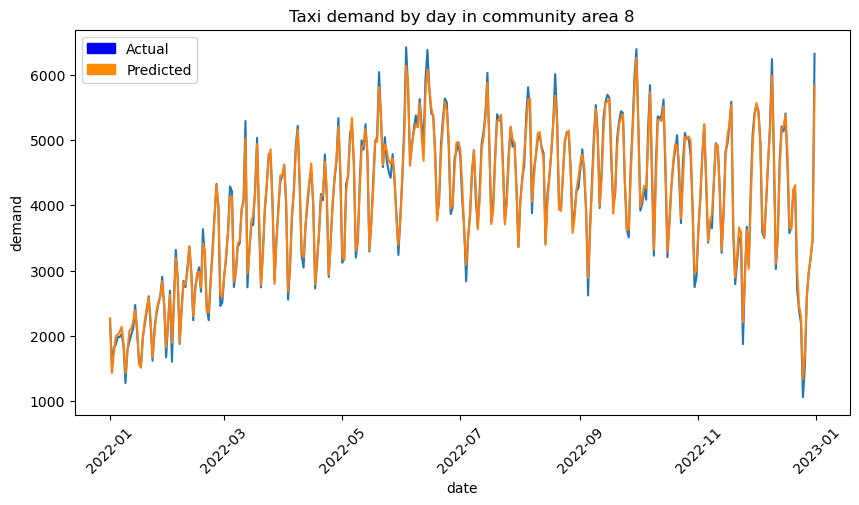

In [176]:
check_predictions(8)

In [168]:
def feature_importance(area):
    importances = pd.DataFrame(data=list(models[area].stages[-1].featureImportances), 
                               columns=['importance'])
    importances['feature'] = feature_cols
    top_5 = importances.sort_values(by='importance',ascending=False).head()
    return top_5

In [173]:
feature_importance(8)

importance         feature
9     0.770871           lag_1
6     0.070990            hour
12    0.048293          lag_24
3     0.023595         weekday
14    0.023507  rolling_mean_6

Interim conclusion:

    Even though MAEs for area 8 are pretty high, the model seems to capture the general trend of the data. For most areas the most usefull features were 'lag_1', 'hour' and 'lag_24'. 

# Conclusion

The resulting MAEs are within acceptable range for most models. However, metrics could be improved for busy areas. On the plot above, for area 8, average demand is at about 4000. Hence, average hourly demand is at 4000/24 ~ 166. MAE for area 8 is 22, which means that, on average, predictions diverge from mean hourly demand by 22/166 ~ 13% which is acceptable. Perhaps, the bigger MAEs for busier areas have nothing to do with these particular areas or their models, but with the larger scale of the demand

One thing to improve upon is one-hot encoding, scaling or normalizing features, using different, more sofisticated models